<a href="https://colab.research.google.com/github/jjasira/Stochastic-modeling/blob/main/TeamMemberC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving MScFE 622_Stochastic Modeling_GWP1_Option data (1).xlsx to MScFE 622_Stochastic Modeling_GWP1_Option data (1).xlsx


In [ ]:
import pandas as pd
df = pd.read_excel('MScFE 622_Stochastic Modeling_GWP1_Option data (1).xlsx')
df

,Days to maturity,Strike,Price,Type
0,15,227.5,10.520000,C
1,15,230.0,10.050000,C
2,15,232.5,7.750000,C
3,15,235.0,6.010000,C
4,15,237.5,4.750000,C
5,60,227.5,16.780000,C
6,60,230.0,17.650000,C
7,60,232.5,16.860000,C
8,60,235.0,16.050000,C
9,60,237.5,15.100000,C


In [ ]:
import numpy as np
import pandas as pd
import time
from scipy.optimize import minimize

In [ ]:
spot = 232.9
r = 0.015
trading_days = 250

In [ ]:
df['Days to maturity'] = pd.to_numeric(df['Days to maturity'], errors='coerce')

market_15 = df[df['Days to maturity']==15].reset_index(drop=True)
market_60 = df[df['Days to maturity']==60].reset_index(drop=True)

print("Market data rows: 15-day:", len(market_15), "; 60-day:", len(market_60))

Market data rows: 15-day: 10 ; 60-day: 10


In [ ]:
# helper: convert puts to calls by put-call parity if needed
def market_price_to_call(row, spot, r, T):
    if str(row['Type']).strip().lower().startswith('c'):
        return row['Price']
    else:
        K = row['Strike']; P = row['Price']
        return P + spot - K * np.exp(-r*T)

In [ ]:
def simulate_heston_paths(S0, v0, r, kappa, theta, sigma_v, rho, T, n_steps, n_sims):
    dt = T / n_steps
    S = np.full((n_sims, n_steps+1), S0, dtype=np.float64)
    v = np.full((n_sims, n_steps+1), v0, dtype=np.float64)
    sqrt_dt = np.sqrt(dt)
    for t in range(1, n_steps+1):
        z1 = np.random.normal(size=n_sims)
        z2 = np.random.normal(size=n_sims)
        w1 = z1
        w2 = rho * z1 + np.sqrt(1 - rho**2) * z2
        v_prev = v[:, t-1]
        v_next = v_prev + kappa*(theta - np.maximum(v_prev, 0)) * dt + sigma_v * np.sqrt(np.maximum(v_prev,0)) * sqrt_dt * w2
        v_next = np.maximum(v_next, 0)
        v[:, t] = v_next
        S_prev = S[:, t-1]
        S[:, t] = S_prev * np.exp((r - 0.5 * v_prev) * dt + np.sqrt(np.maximum(v_prev, 0)) * sqrt_dt * w1)
    return S, v

In [ ]:
def simulate_bates_paths(S0, v0, r, kappa, theta, sigma_v, rho, T, n_steps, n_sims, lambda_j=0.0, mu_j=0.0, delta_j=0.0):
    dt = T / n_steps
    S = np.full((n_sims, n_steps+1), S0, dtype=np.float64)
    v = np.full((n_sims, n_steps+1), v0, dtype=np.float64)
    sqrt_dt = np.sqrt(dt)
    for t in range(1, n_steps+1):
        z1 = np.random.normal(size=n_sims)
        z2 = np.random.normal(size=n_sims)
        w1 = z1
        w2 = rho * z1 + np.sqrt(1 - rho**2) * z2
        v_prev = v[:, t-1]
        v_next = v_prev + kappa*(theta - np.maximum(v_prev, 0)) * dt + sigma_v * np.sqrt(np.maximum(v_prev,0)) * sqrt_dt * w2
        v_next = np.maximum(v_next, 0)
        v[:, t] = v_next
        Nj = np.random.poisson(lambda_j * dt, size=n_sims)
        jump_multiplier = np.ones(n_sims)
        mask = Nj > 0
        if mask.any():
            # compound lognormal jumps per path
            idxs = np.where(mask)[0]
            for idx in idxs:
                n_jumps = Nj[idx]
                y = np.random.normal(loc=mu_j, scale=delta_j, size=n_jumps)
                jump_multiplier[idx] = np.exp(y.sum())
        S_prev = S[:, t-1]
        S[:, t] = S_prev * np.exp((r - 0.5 * v_prev) * dt + np.sqrt(np.maximum(v_prev, 0)) * sqrt_dt * w1) * jump_multiplier
    return S, v

In [ ]:
# -----------------------------
# PART A: Calibrate Heston to 15-day market (Monte-Carlo based calibration)
# -----------------------------
T15 = 15 / trading_days
strikes_15 = market_15['Strike'].values
prices_15 = np.array([market_price_to_call(row, spot, r, T15) for _, row in market_15.iterrows()])

print("15-day strikes:", strikes_15)
print("15-day target call prices:", np.round(prices_15,4))

15-day strikes: [227.5 230.  232.5 235.  237.5 227.5 230.  232.5 235.  237.5]
15-day target call prices: [10.52   10.05    7.75    6.01    4.75    9.9247  8.3069  7.0592  5.6714
  4.3937]


In [ ]:
# helper pricing for European calls under Heston (terminal price)
def heston_european_mc_price(S0, r, kappa, theta, sigma_v, rho, v0, T, n_steps, n_sims, strikes):
    S, _ = simulate_heston_paths(S0, v0, r, kappa, theta, sigma_v, rho, T, n_steps, n_sims)
    ST = S[:,-1]
    disc = np.exp(-r*T)
    prices = [disc * np.mean(np.maximum(ST - K, 0)) for K in strikes]
    return np.array(prices)

In [ ]:
# objective: SSE across strikes
def heston_obj(params):
    kappa, theta, sigma_v, rho, v0 = params
    if any([kappa<=0, theta<=0, sigma_v<=0, v0<=0, abs(rho)>=1]):
        return 1e9
    np.random.seed(123)
    model = heston_european_mc_price(spot, r, kappa, theta, sigma_v, rho, v0, T15, 15, 20000, strikes_15)
    return np.sum((model - prices_15)**2)

In [ ]:
# initial guess and bounds
x0 = np.array([1.2, 0.04, 0.3, -0.6, 0.04])
bnds = [(0.01,5.0),(1e-4,0.5),(1e-4,2.0),(-0.999,0.999),(1e-4,0.5)]

print('Starting Heston calibration (this may take ~20-40s)')
start = time.time()
res_heston = minimize(heston_obj, x0, bounds=bnds, method='L-BFGS-B', options={'maxiter':40})
end = time.time()
print('Heston optimization success:', res_heston.success, res_heston.message)
print('Elapsed (s):', round(end-start,2))
heston_calibrated = res_heston.x
print('Calibrated Heston params (15d): kappa, theta, sigma_v, rho, v0', heston_calibrated)

Starting Heston calibration (this may take ~20-40s)
Heston optimization success: True CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Elapsed (s): 13.48
Calibrated Heston params (15d): kappa, theta, sigma_v, rho, v0 [ 1.18771650e+00  1.00000000e-04  1.48750254e+00 -8.13610674e-01
  1.06527028e-01]


In [ ]:
# -----------------------------
# PART B: Price ATM Asian call (20 trading days) using calibrated Heston
# -----------------------------
T20 = 20 / trading_days
n_steps20 = 20
n_sims_high = 100000
kappa_c, theta_c, sigma_v_c, rho_c, v0_c = heston_calibrated

np.random.seed(2025)
S_sim20, _ = simulate_heston_paths(spot, v0_c, r, kappa_c, theta_c, sigma_v_c, rho_c, T20, n_steps20, n_sims_high)
avg_S20 = S_sim20.mean(axis=1)
payoffs20 = np.maximum(avg_S20 - spot, 0)
price20 = np.exp(-r*T20) * np.mean(payoffs20)
stderr20 = np.exp(-r*T20) * np.std(payoffs20) / np.sqrt(n_sims_high)
client_price20 = price20 * 1.04

print('Asian 20-day price (using Heston calibrated to 15d):')
print('Price:', round(price20,6), 'StdErr:', round(stderr20,6), 'Client price (incl 4%):', round(client_price20,6))

Asian 20-day price (using Heston calibrated to 15d):
Price: 4.78541 StdErr: 0.018548 Client price (incl 4%): 4.976826


In [ ]:
# -----------------------------
# PART C: Calibrate Bates to 60-day market (fix Heston core to above, recover jump params)
# -----------------------------
T60 = 60 / trading_days
strikes_60 = market_60['Strike'].values
prices_60 = np.array([market_price_to_call(row, spot, r, T60) for _, row in market_60.iterrows()])

print('60-day strikes:', strikes_60)
print('60-day target call prices:', np.round(prices_60,4))

60-day strikes: [227.5 230.  232.5 235.  237.5 227.5 230.  232.5 235.  237.5]
60-day target call prices: [16.78   17.65   16.86   16.05   15.1    17.2475 15.8765 14.6055 13.4945
 11.8735]


**STEP 2.A**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import brute, fmin

Our first task in calibrating the Bates (1996) model will be to calibrate Heston (1993) model to observed market data.

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import brute, fmin, minimize
from math import exp

In [ ]:
df_all = pd.read_excel('MScFE 622_Stochastic Modeling_GWP1_Option data (1).xlsx', sheet_name=0)

# Inspect columns to match format
print(df.head())

   Days to maturity  Strike  Price Type
0                15   227.5  10.52    C
1                15   230.0  10.05    C
2                15   232.5   7.75    C
3                15   235.0   6.01    C
4                15   237.5   4.75    C


In [ ]:
S0 = 232.90
r = 0.015
days_in_year = 250

df60 = df_all[df_all['Days to maturity'] == 60].copy().reset_index(drop=True)

In [ ]:
# Convert puts into equivalent call prices via put-call parity when needed:
# C = P + S0 - K * exp(-r*T)
def to_call(row):
    T = row['Days to maturity'] / days_in_year
    K = row['Strike']
    if row['Type'].strip().upper() == 'C':
        return {'Strike': K, 'T': T, 'Call': row['Price'], 'r': r}
    else:
        P = row['Price']
        C = P + S0 - K * np.exp(-r * T)
        return {'Strike': K, 'T': T, 'Call': C, 'r': r}

In [ ]:
options_list = [to_call(row) for _, row in df60.iterrows()]
options = pd.DataFrame(options_list)
options

,Strike,T,Call,r
0,227.5,0.24,16.780000,0.015
1,230.0,0.24,17.650000,0.015
2,232.5,0.24,16.860000,0.015
3,235.0,0.24,16.050000,0.015
4,237.5,0.24,15.100000,0.015
5,227.5,0.24,17.247528,0.015
6,230.0,0.24,15.876511,0.015
7,232.5,0.24,14.605495,0.015
8,235.0,0.24,13.494479,0.015
9,237.5,0.24,11.873463,0.015


In [ ]:
globals().update({'options': options, 'S0': S0})

print("Calibration dataset (60-day, converted calls):")
print(options.to_string(index=False))

Calibration dataset (60-day, converted calls):
 Strike    T      Call     r
  227.5 0.24 16.780000 0.015
  230.0 0.24 17.650000 0.015
  232.5 0.24 16.860000 0.015
  235.0 0.24 16.050000 0.015
  237.5 0.24 15.100000 0.015
  227.5 0.24 17.247528 0.015
  230.0 0.24 15.876511 0.015
  232.5 0.24 14.605495 0.015
  235.0 0.24 13.494479 0.015
  237.5 0.24 11.873463 0.015


In [ ]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

In [ ]:
def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    char_func_value = H93_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

In [ ]:
def H93_call_value(S0_, K, T, r_, kappa_v, theta_v, sigma_v, rho, v0):
    int_value = quad(
        lambda u: H93_int_func(u, S0_, K, T, r_, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0_ - np.exp(-r_ * T) * np.sqrt(S0_ * K) / np.pi * int_value)
    return call_value

In [ ]:
# Build arrays of strikes/T/market prices for efficiency
strikes = options['Strike'].values
Ts = options['T'].values
market_calls = options['Call'].values

In [ ]:

def heston_mse(params):
    # params = [kappa, theta, sigma_v, rho, v0]
    kappa, theta, sigma_v, rho, v0 = params
    # basic bounds penalty
    if kappa <= 0 or theta <= 0 or sigma_v <= 0 or v0 <= 0 or abs(rho) >= 1:
        return 1e9
    # Feller condition soft check: we don't hard require it yet, but penalize if violated heavily
    if 2*kappa*theta < sigma_v**2:
        # penalize but don't discard entirely (some calibrations accept near-boundary)
        penalty = 1e4
    else:
        penalty = 0.0
    errs = []
    for K, T, mkt in zip(strikes, Ts, market_calls):
        try:
            model_p = H93_call_value(S0, K, T, r, kappa, theta, sigma_v, rho, v0)
        except Exception:
            return 1e9
        errs.append((model_p - mkt)**2)
    return float(np.mean(errs)) + penalty

In [ ]:
# coarse grid ranges for brute
ranges = (
    slice(0.1, 3.0, 0.6),    # kappa
    slice(1e-4, 0.2, 0.05),  # theta
    slice(0.05, 1.0, 0.225), # sigma_v
    slice(-0.99, -0.1, 0.295), # rho (equities typically negative)
    slice(1e-4, 0.3, 0.075)  # v0
)

print("Running coarse brute-force grid search for Heston (60-day)...")
brute_res = brute(heston_mse, ranges, finish=None)
print("Brute approx result:", brute_res)

print("Refining Heston parameters with local optimizer (fmin)...")
heston_local = fmin(heston_mse, brute_res, maxiter=200, maxfun=400, disp=True)
kappa_v, theta_v, sigma_v, rho, v0 = heston_local
print("\nHeston calibrated (60-day) parameters:")
print(f" kappa = {kappa_v:.6f}, theta = {theta_v:.6f}, sigma_v = {sigma_v:.6f}, rho = {rho:.6f}, v0 = {v0:.6f}")


Running coarse brute-force grid search for Heston (60-day)...


/tmp/ipython-input-780178548.py:2: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(


Brute approx result: [ 2.5     0.0501  0.5    -0.4     0.1501]
Refining Heston parameters with local optimizer (fmin)...

Heston calibrated (60-day) parameters:
 kappa = 8.841303, theta = 0.018041, sigma_v = 0.564765, rho = 0.998940, v0 = 0.236362


/tmp/ipython-input-3784416304.py:15: RuntimeWarning: Maximum number of iterations has been exceeded.
  heston_local = fmin(heston_mse, brute_res, maxiter=200, maxfun=400, disp=True)


In [ ]:
# Expose Heston params globally for Bates helper functions (they reference these names)
globals().update({'kappa_v': kappa_v, 'theta_v': theta_v, 'sigma_v': sigma_v, 'rho': rho, 'v0': v0})

**Bates helpers (Merton jump CF, Bates CF, Bates pricing) - use as provided (unchanged)**

In [ ]:
def M76J_char_func(u, T, lamb, mu, delta):
    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

def B96_char_func(u, T, r_, kappa_v_, theta_v_, sigma_v_, rho_, v0_, lamb, mu, delta):
    H93 = H93_char_func(u, T, r_, kappa_v_, theta_v_, sigma_v_, rho_, v0_)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

def B96_int_func(u, S0_, K, T, r_, kappa_v_, theta_v_, sigma_v_, rho_, v0_, lamb, mu, delta):
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r_, kappa_v_, theta_v_, sigma_v_, rho_, v0_, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0_ / K)) * char_func_value).real
    )
    return int_func_value

def B96_call_value(S0_, K, T, r_, kappa_v_, theta_v_, sigma_v_, rho_, v0_, lamb, mu, delta):
    int_value = quad(
        lambda u: B96_int_func(u, S0_, K, T, r_, kappa_v_, theta_v_, sigma_v_, rho_, v0_, lamb, mu, delta),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0_ - np.exp(-r_ * T) * np.sqrt(S0_ * K) / np.pi * int_value)
    return call_value

In [ ]:
# Provided B96 error function and calibration routines (kept structurally the same)
# We adapt a few globals referenced inside them: i, min_MSE, local_opt, opt1, options, S0, kappa_v, theta_v, sigma_v, rho, v0
i = 0
min_MSE = 1e9
local_opt = False
opt1 = None

def B96_error_function(p0):
    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    # boundaries as provided
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Call"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt and (opt1 is not None):
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

In [ ]:
# Short calibration routine (brute + fmin) as provided
def B96_calibration_short():
    global opt1, i, min_MSE, local_opt
    i = 0
    min_MSE = 1e9
    local_opt = False
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),   # lambda grid (0 to 0.5 step 0.1)
            (-0.5, -0.11, 0.1), # mu grid (-0.5 to -0.11 step 0.1)
            (0.0, 0.51, 0.25),  # delta grid (0 to 0.5 step 0.25)
        ),
        finish=None,
    )
    # run local refine with penalty enabled
    local_opt = True
    # set opt1 for penalty center
    # note: the helper expects opt1 used in penalty; set it globally
    globals()['opt1'] = opt1
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=1e-7,
        ftol=1e-7,
        maxiter=550,
        maxfun=750,
        disp=True,
    )
    # reset local_opt
    local_opt = False
    return opt2

In [ ]:
# Full calibration helper (Heston + jumps) using provided B96_full_error_function logic:
# We'll reimplement the provided full-error function exactly as given and a wrapper to run fmin
# (we need a p0 vector - we will construct it after the short jump calibration)
i = 0
min_MSE = 1e9

def B96_full_error_function(p0):
    global i, min_MSE
    kappa_v_, theta_v_, sigma_v_, rho_, v0_, lamb_, mu_, delta_ = p0
    # guard constraints as in provided code
    if (
        kappa_v_ < 0.0
        or theta_v_ < 0.005
        or sigma_v_ < 0.0
        or rho_ < -1.0
        or rho_ > 1.0
        or v0_ < 0.0
        or lamb_ < 0.0
        or mu_ < -0.6
        or mu_ > 0.0
        or delta_ < 0.0
    ):
        return 5000.0
    if 2 * kappa_v_ * theta_v_ < sigma_v_**2:
        return 5000.0

    se = []
    for row, option in options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v_,
            theta_v_,
            sigma_v_,
            rho_,
            v0_,
            lamb_,
            mu_,
            delta_,
        )
        se.append((model_value - option["Call"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

def B96_calibration_full(p0_initial):
    global i, min_MSE
    i = 0
    min_MSE = 1e9
    opt = fmin(
        B96_full_error_function, p0_initial, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650, disp=True
    )
    return opt

In [ ]:
# -----------------------------------------
# 5) Run the Bates short (jump-only) calibration
# -----------------------------------------
print("\nRunning Bates short (jump-only) calibration using Heston params as fixed...")
bates_jump_params = B96_calibration_short()
lamb_hat, mu_hat, delta_hat = bates_jump_params
print("\nCalibrated Bates jump parameters (short):")
print(f" lambda = {lamb_hat:.6f}, mu = {mu_hat:.6f}, delta = {delta_hat:.6f}")


Running Bates short (jump-only) calibration using Heston params as fixed...
   0 | [ 0.  -0.5  0. ] |   1.414 |   1.414
  25 | [ 0.2  -0.5   0.25] |   3.450 |   1.414
  50 | [ 0.4 -0.5  0.5] |  13.031 |   1.414
  75 | [ 0.0e+00 -5.0e-01  2.5e-04] |   1.414 |   1.414
 100 | [ 2.73169723e-05 -5.00007974e-01  4.43300872e-05] |   1.414 |   1.414
 125 | [ 9.61535680e-07 -5.00001071e-01  1.23811994e-06] |   1.414 |   1.414
Optimization terminated successfully.
         Current function value: 1.413652
         Iterations: 63
         Function evaluations: 119

Calibrated Bates jump parameters (short):
 lambda = 0.000000, mu = -0.500000, delta = 0.000000


In [ ]:
# -----------------------------------------
# 6) Optionally run full Bates calibration (Heston + jumps together)
#    WARNING: this is computationally heavy. Use only if needed.
# -----------------------------------------
run_full = True  # set False to skip full calibration
if run_full:
    print("\nRunning FULL Bates calibration (Heston + jumps). This may take significant time...")
    # initial vector p0: [kappa, theta, sigma_v, rho, v0, lambda, mu, delta]
    p0 = np.array([kappa_v, theta_v, sigma_v, rho, v0, lamb_hat, mu_hat, delta_hat])
    full_opt = B96_calibration_full(p0)
    kappa_f, theta_f, sigma_f, rho_f, v0_f, lamb_f, mu_f, delta_f = full_opt
    print("\nFULL Bates calibrated parameters:")
    print(f" kappa = {kappa_f:.6f}, theta = {theta_f:.6f}, sigma_v = {sigma_f:.6f}, rho = {rho_f:.6f}, v0 = {v0_f:.6f}")
    print(f" lambda = {lamb_f:.6f}, mu = {mu_f:.6f}, delta = {delta_f:.6f}")
else:
    print("\nSkipping full Bates calibration (set run_full=True to enable).")



Running FULL Bates calibration (Heston + jumps). This may take significant time...
   0 | [ 8.84130274  0.01804082  0.56476503  0.99893989  0.23636179  0.
 -0.5         0.        ] |   1.414 |   1.414
  25 | [ 8.88289322e+00  1.82010200e-02  5.64123495e-01  9.92364625e-01
  2.38398030e-01  4.43991311e-05 -5.04439913e-01  4.43991311e-05] |   1.416 |   1.414
  50 | [ 8.84297802e+00  1.81944000e-02  5.64782519e-01  9.98698045e-01
  2.36417473e-01  4.49996767e-05 -5.05378874e-01  5.37887392e-05] |   1.414 |   1.413
  75 | [ 8.83447153e+00  1.81905699e-02  5.65675052e-01  9.99799473e-01
  2.36413000e-01  7.21766138e-05 -4.95151062e-01  1.64388275e-04] |   1.413 |   1.413
 100 | [ 8.83266242e+00  1.81942768e-02  5.66097171e-01  9.99849381e-01
  2.36446700e-01  5.49346979e-06 -4.98867726e-01  1.37260329e-04] |   1.413 |   1.413
 125 | [ 8.83136734e+00  1.82990552e-02  5.66785908e-01  9.99911570e-01
  2.36460631e-01  4.20917927e-06 -5.09411518e-01  1.98650321e-04] |   1.413 |   1.413
 150 | [

In [ ]:
used_params = (kappa_f, theta_f, sigma_f, rho_f, v0_f, lamb_f, mu_f, delta_f)
used_params

(np.float64(8.995653549873438),
 np.float64(0.024854694498543273),
 np.float64(0.6140808581119154),
 np.float64(0.9795972092148496),
 np.float64(0.23066653371536122),
 np.float64(0.000995488944562371),
 np.float64(-0.00012090520197645979),
 np.float64(0.015645598867975265))

In [ ]:
model_vals = []
for _, optrow in options.iterrows():
    model_p = B96_call_value(
        S0,
        optrow['Strike'],
        optrow['T'],
        optrow['r'],
        used_params[0], used_params[1], used_params[2], used_params[3], used_params[4],
        used_params[5], used_params[6], used_params[7]
    )
    model_vals.append(model_p)

fit_df = options.copy()
fit_df['Model'] = model_vals
fit_df['Diff'] = fit_df['Model'] - fit_df['Call']

print("\nFit results (60-day):")
print(fit_df.to_string(index=False))


Fit results (60-day):
 Strike    T      Call     r     Model      Diff
  227.5 0.24 16.780000 0.015 17.735069  0.955069
  230.0 0.24 17.650000 0.015 16.580752 -1.069248
  232.5 0.24 16.860000 0.015 15.494013 -1.365987
  235.0 0.24 16.050000 0.015 14.472112 -1.577888
  237.5 0.24 15.100000 0.015 13.512231 -1.587769
  227.5 0.24 17.247528 0.015 17.735069  0.487541
  230.0 0.24 15.876511 0.015 16.580752  0.704240
  232.5 0.24 14.605495 0.015 15.494013  0.888518
  235.0 0.24 13.494479 0.015 14.472112  0.977633
  237.5 0.24 11.873463 0.015 13.512231  1.638768


In [ ]:
calib_summary = {
    'kappa': used_params[0],
    'theta': used_params[1],
    'sigma_v': used_params[2],
    'rho': used_params[3],
    'v0': used_params[4],
    'lambda': used_params[5],
    'mu': used_params[6],
    'delta': used_params[7]
}
calib_summary

{'kappa': np.float64(8.995653549873438),
 'theta': np.float64(0.024854694498543273),
 'sigma_v': np.float64(0.6140808581119154),
 'rho': np.float64(0.9795972092148496),
 'v0': np.float64(0.23066653371536122),
 'lambda': np.float64(0.000995488944562371),
 'mu': np.float64(-0.00012090520197645979),
 'delta': np.float64(0.015645598867975265)}

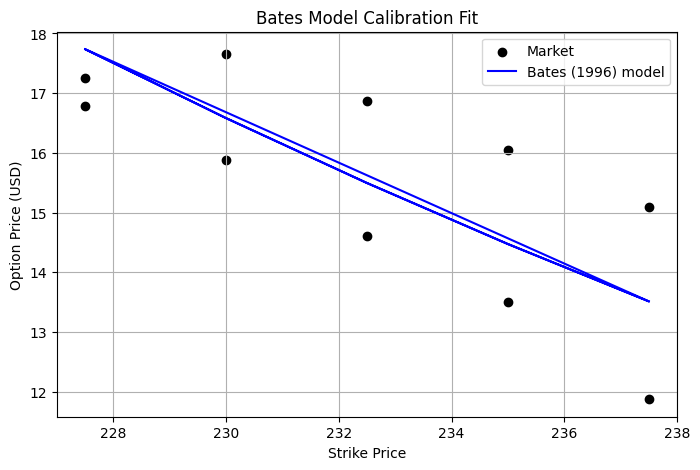

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(options['Strike'], options['Call'], color='black', label='Market')
plt.plot(options['Strike'], model_vals, color='blue', label='Bates (1996) model')
plt.title("Bates Model Calibration Fit")
plt.xlabel("Strike Price")
plt.ylabel("Option Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import splev, splrep
from scipy.optimize import fmin

In [ ]:
mat_list = np.array((7, 30, 90, 180, 360)) / 360
rate_list = (
    np.array((0.648, 0.679, 1.173, 1.809, 2.556)) / 100
)

In [ ]:
r0 = rate_list[0]
factors = 1 + mat_list * rate_list
zero_rates = 1 / mat_list * np.log(factors)

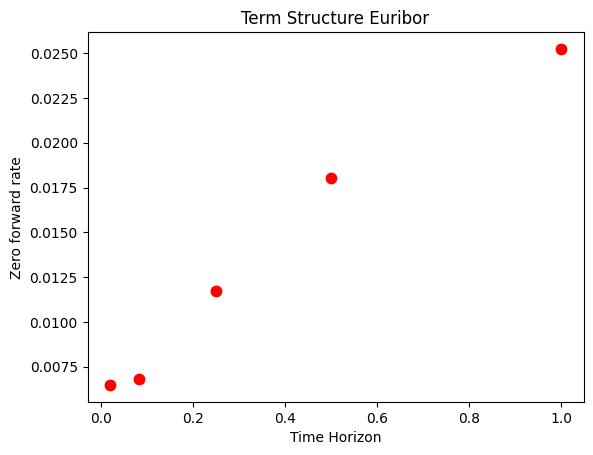

In [ ]:
plt.plot(mat_list, zero_rates, "r.", markersize="15")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.show()

In [ ]:
bspline = splrep(mat_list, zero_rates, k=3)  # Cubic spline
mat_list_n = np.linspace(
    0.0, 1.0, 24
)  # Create 24 equally spaced maturities between 0 and 1
inter_rates = splev(mat_list_n, bspline, der=0)  # Interpolated rates

first_der = splev(mat_list_n, bspline, der=1)  # First derivative of spline
f = (
    inter_rates + first_der * mat_list_n
)  # Forward rate given interpolated ones and first derivative

Now, let's compare the output of our interpolation with the observed market quotes

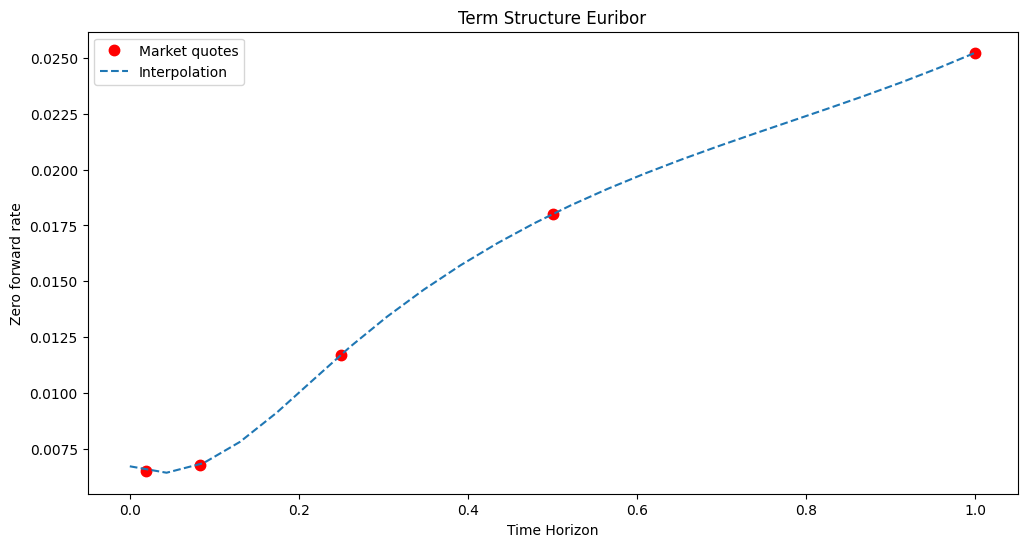

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(mat_list, zero_rates, "r.", markersize="15", label="Market quotes")
plt.plot(mat_list_n, inter_rates, "--", markersize="10", label="Interpolation")
#plt.plot(mat_list_n, first_der, "g--", markersize="10", label="1st derivative")  # You may also want to depict the 1st derivative computation, to see how this behaves. Uncomment this line of code to do so.
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

In [ ]:
def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)-1)) ** 2)


    return s1 + s2

In [ ]:
def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """

    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

In [ ]:
def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
    )

    return opt

In [ ]:
params = CIR_calibration()
params

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 173
         Function evaluations: 303


array([1.22277618e+00, 1.02619406e-01, 1.00256274e-03])

In [ ]:
def plot_calibrated_frc(opt):
    """Plots market and calibrated forward rate curves."""
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.title("CIR model calibration")
    plt.ylabel("Forward rate $f(0,T)$")
    plt.plot(mat_list_n, f, "ro", label="market")
    plt.plot(mat_list_n, forward_rates, "b--", label="model")
    plt.legend(loc=0)
    plt.axis(
        [min(mat_list_n) - 0.05, max(mat_list_n) + 0.05, min(f) - 0.005, max(f) * 1.1]
    )
    plt.subplot(212)
    wi = 0.02
    plt.bar(mat_list_n - wi / 2, forward_rates - f, width=wi)
    plt.xlabel("Time horizon")
    plt.ylabel("Difference")
    plt.axis(
        [
            min(mat_list_n) - 0.05,
            max(mat_list_n) + 0.05,
            min(forward_rates - f) * 1.1,
            max(forward_rates - f) * 1.1,
        ]
    )
    plt.tight_layout()

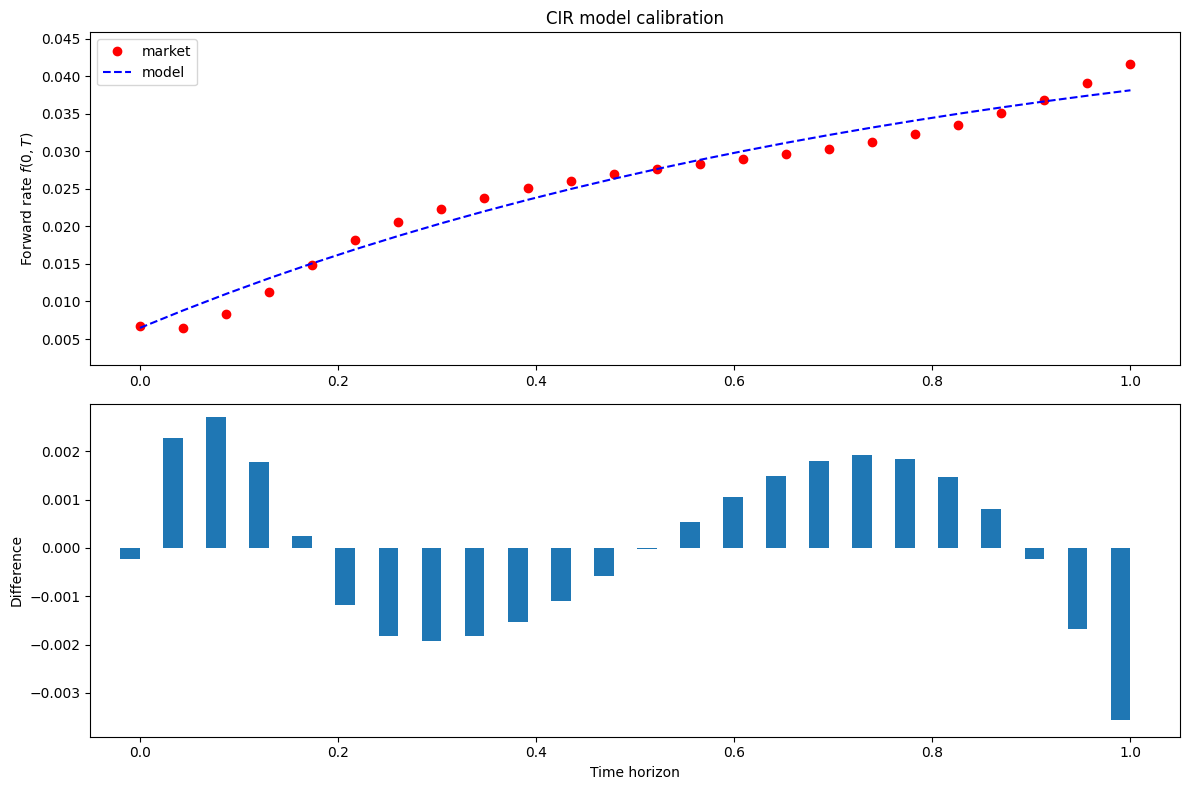

In [ ]:
plot_calibrated_frc(params)


Expected 12M Euribor in 1 year: 7.4372%
95% confidence interval: 7.4079% – 7.4662%
Current 12M Euribor: 2.5560%


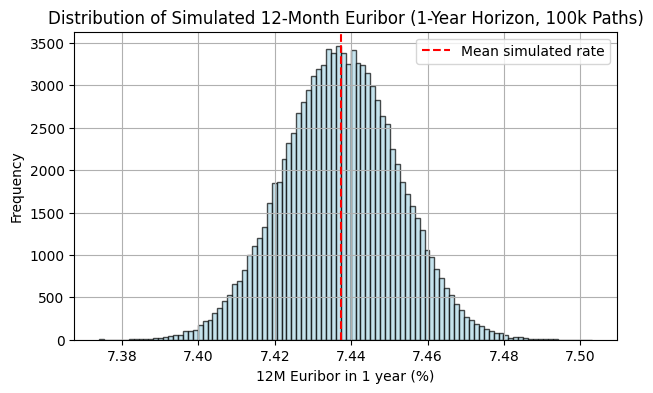

In [ ]:
# -----------------------------
# 5. Monte Carlo simulation of CIR process
# -----------------------------
kappa, theta, sigma = params
def simulate_CIR_paths(r0, kappa, theta, sigma, T=1.0, steps=252, n_paths=100000):
    dt = T/steps
    rates = np.zeros((n_paths, steps+1))
    rates[:,0] = r0
    for t in range(steps):
        rt = rates[:,t]
        dr = kappa*(theta - rt)*dt + sigma*np.sqrt(np.maximum(rt,0))*np.sqrt(dt)*np.random.randn(n_paths)
        rates[:,t+1] = np.maximum(rt + dr, 0)
    return rates

# Simulate 100k paths daily for 1 year
paths = simulate_CIR_paths(r0, kappa, theta, sigma, T=1, steps=365, n_paths=100000)
rT = paths[:,-1]

mean_rT = np.mean(rT)
conf_int = np.percentile(rT, [2.5, 97.5])

print(f"\nExpected 12M Euribor in 1 year: {mean_rT*100:.4f}%")
print(f"95% confidence interval: {conf_int[0]*100:.4f}% – {conf_int[1]*100:.4f}%")
print(f"Current 12M Euribor: {rate_list[-1]*100:.4f}%")

summary_df = pd.DataFrame({
    "mean": [mean_rT],
    "lower_95": [conf_int[0]],
    "upper_95": [conf_int[1]],
    "current_12m": [rate_list[-1]]
})

# Plot simulated distribution
plt.figure(figsize=(7,4))
plt.hist(rT*100, bins=100, color='lightblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_rT*100, color='r', linestyle='--', label='Mean simulated rate')
plt.xlabel("12M Euribor in 1 year (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Simulated 12-Month Euribor (1-Year Horizon, 100k Paths)")
plt.legend()
plt.grid(True)
plt.show()